# Задание 1 
Чекаут - один из ключевых составляющих продукта. Чекаут - форма, которую 
видит пользователь (донор), когда собирается сделать пожертвование. Первый экран 
чекаута - экран с выбором размера пожертвования. Пользователь может выбрать размер 
пожертвования из подсказок на экране, либо ввести сумму самостоятельно. Кроме того, 
пользователь может сделать разовое пожертвования (вкладка “Give once”), либо сделать 
регулярное пожертвование (вкладка “Monthly”).  
Был проведен АБ-тест, в котором было протестировано одно изменение: на вкладке “Give 
once” убрано предзаполнение поля ввода суммы. До этого поле было предзаполнено 
значением одной из подсказок. На рисунке ниже слева - контрольная группа, справа - 
тестовая.

Задача:  
1) Определить метрики, на которые стоит смотреть в тесте, и объяснить свой выбор 
2) Проанализировать АБ-тест 
3) Составить рекомендации по результатам анализа. 

В файле FRU_analytics_task1.csv находятся исходные логи АБ-теста: 
- ClientID - ID пользователя 
- EventTime - время события 
- EventType - тип события (checkoutView - открытие чекаута, charge - создание доната) 
- DonationType - тип доната (one-time - разовый доната, recurring - регулярный донат с 
частотой списания раз в месяц). 
- AmountInUSD - размер доната в $. 
- tag - группа, в которую попал пользователь (control/test) 

Формат: Jupyter notebook (желательно) или R markdown с расчетами и комментариями 

In [8]:
import pandas as pd
import plotly.express as px

In [9]:
df = pd.read_csv('FRU_analytics_test_task1 (1).csv')

In [20]:
df.head(5)

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag
0,885410877,2022-07-20 00:00:23,checkoutView,NaN,NaN,control
1,859319263,2022-07-20 00:00:48,checkoutView,NaN,NaN,test
2,480984859,2022-07-20 00:00:58,checkoutView,NaN,NaN,control
3,204664871,2022-07-20 00:01:00,checkoutView,NaN,NaN,test
4,859319263,2022-07-20 00:01:05,checkoutView,NaN,NaN,test


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58770 entries, 0 to 58769
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ClientID      58770 non-null  int64  
 1   EventTime     58770 non-null  object 
 2   EventType     58770 non-null  object 
 3   DonationType  5364 non-null   object 
 4   AmountInUSD   5364 non-null   float64
 5   tag           53406 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 2.7+ MB


In [9]:
df.describe(include='all')

,ClientID,EventTime,EventType,DonationType,AmountInUSD,tag
count,5.877000e+04,58770,58770,5364,5364.000000,53406
unique,NaN,56079,2,2,NaN,2
top,NaN,2022-07-25 20:54:17,checkoutView,one-time,NaN,test
freq,NaN,4,53406,5189,NaN,26764
mean,5.486131e+08,NaN,NaN,NaN,78.335943,NaN
std,2.605868e+08,NaN,NaN,NaN,177.197650,NaN
min,1.000159e+08,NaN,NaN,NaN,5.000000,NaN
25%,3.224909e+08,NaN,NaN,NaN,20.000000,NaN
50%,5.463478e+08,NaN,NaN,NaN,50.000000,NaN
75%,7.758130e+08,NaN,NaN,NaN,106.000000,NaN


In [19]:
# Изучим уникальные значения категориальных атрибутов

for col in ['EventType', 'tag', 'DonationType']:
    print(col + ':', df[col].unique())

EventType: ['checkoutView' 'charge']
tag: ['control' 'test' nan]
DonationType: [nan 'one-time' 'recurring']


In [32]:
df.groupby('EventType').count()

,ClientID,EventTime,DonationType,AmountInUSD,tag
EventType,,,,,
charge,5364,5364,5364,5364,5364
checkoutView,53406,53406,53406,53406,53406


In [33]:
df.fillna('no test').groupby('tag').count()

,ClientID,EventTime,EventType,DonationType,AmountInUSD
tag,,,,,
control,26642,26642,26642,26642,26642
no test,5364,5364,5364,5364,5364
test,26764,26764,26764,26764,26764


In [34]:
df.fillna('no test').groupby(['EventType', 'tag']).count()

ClientID  EventTime  DonationType  AmountInUSD
EventType    tag                                                    
charge       no test      5364       5364          5364         5364
checkoutView control     26642      26642         26642        26642
             test        26764      26764         26764        26764

In [35]:
df.fillna('no test').groupby('DonationType').count()

,ClientID,EventTime,EventType,AmountInUSD,tag
DonationType,,,,,
no test,53406,53406,53406,53406,53406
one-time,5189,5189,5189,5189,5189
recurring,175,175,175,175,175


In [52]:
# Суммы донатов указаны в событиях без тега контрольной/тестовой группы

df.fillna(0).groupby('tag').agg({'AmountInUSD': 'sum'})

,AmountInUSD
tag,
0,420194.0
control,0.0
test,0.0


In [53]:
# На всякий случай проверим, нет ли клиентов, попавших в обе группы

df.groupby('ClientID').agg({'tag': 'nunique'}).max()

tag    1
dtype: int64

In [127]:
# проверим, что дата первого события типа charge для каждого клиента идет после первого события типа checkoutView, чтобы быть уверенными, что все charge входят в период теста

min_event_dates = df.groupby(['ClientID', 'EventType'], as_index=False).agg({'EventTime': 'min'})
min_event_dates_pivot = min_event_dates.pivot(index='ClientID', columns='EventType', values='EventTime')
min_event_dates_pivot[min_event_dates_pivot['charge'] < min_event_dates_pivot['checkoutView']] 

EventType,charge,checkoutView
ClientID,,


In [73]:
# Т.к. каждый клиент попадает только в одну группу и донаты идут после checkoutView, можно спокойно разбить клиентов на разные группы и посчитать агрегированные показатели донатов для каждой группы
# Кроме того, следует разделить AmountInUSD на два атрибута в зависимости от DonationType, чтобы проверить эффект теста как для разовых, так и для регулярных донатов

client_group = df.dropna(subset=['tag'])[['ClientID', 'tag']].drop_duplicates()
client_sum = df.groupby(['ClientID', 'DonationType'], as_index=False).agg({'AmountInUSD': 'sum'})\
               .pivot(index='ClientID', columns='DonationType', values='AmountInUSD').reset_index()
client_result = client_group.merge(client_sum, how='left', on='ClientID')
client_result = client_result.rename(columns={"one-time": "AmountInUSD_one_time", "recurring": "AmountInUSD_recurring"})
client_result['Clients_count'] = 1
client_result['Donated_count'] = client_result.apply(lambda x: 1 if x.AmountInUSD_one_time > 0 or x.AmountInUSD_recurring > 0 else 0, axis=1)
client_result['AmountInUSD_one_time_sum'] = client_result['AmountInUSD_one_time']
client_result['AmountInUSD_one_time_mean'] = client_result['AmountInUSD_one_time'].fillna(0)
client_result['AmountInUSD_one_time_median'] = client_result['AmountInUSD_one_time']
client_result['AmountInUSD_one_time_std'] = client_result['AmountInUSD_one_time']
client_result['AmountInUSD_recurring_sum'] = client_result['AmountInUSD_recurring']
client_result['AmountInUSD_recurring_mean'] = client_result['AmountInUSD_recurring'].fillna(0)
client_result['AmountInUSD_recurring_median'] = client_result['AmountInUSD_recurring']
client_result['AmountInUSD_recurring_std'] = client_result['AmountInUSD_recurring']
client_result_agg = client_result\
                    .groupby('tag', as_index=False)\
                    .agg({'AmountInUSD_one_time_sum': 'sum', 
                          'AmountInUSD_one_time_median': 'median', 
                          'AmountInUSD_one_time_mean': 'mean', 
                          'AmountInUSD_one_time_std': 'std', 
                          'AmountInUSD_recurring_sum': 'sum',
                          'AmountInUSD_recurring_mean': 'mean',
                          'AmountInUSD_recurring_median': 'median',
                          'AmountInUSD_recurring_std': 'std',
                          'Clients_count': 'count',
                          'Donated_count': 'sum'})
client_result_agg = client_result_agg[['tag',
                                       'Clients_count',
                                       'Donated_count',
                                       'AmountInUSD_one_time_sum',                                       
                                       'AmountInUSD_recurring_sum',
                                       'AmountInUSD_one_time_mean',
                                       'AmountInUSD_recurring_mean',
                                       'AmountInUSD_one_time_median',
                                       'AmountInUSD_recurring_median',
                                       'AmountInUSD_one_time_std',
                                       'AmountInUSD_recurring_std']]

# посчитаем размер долю задонативших клиентов от всей группы

client_result_agg['Donated_share'] = 100 * client_result_agg['Donated_count']/client_result_agg['Clients_count']

# Получили сумму донатов в обеих группах и средний размер доната для обеих групп и для обоих типов донатов, а также долю задонативших клиентов

client_result_agg.transpose()

,0,1
tag,control,test
Clients_count,21152,21109
Donated_count,2459,2655
AmountInUSD_one_time_sum,199062.0,213239.0
AmountInUSD_recurring_sum,3961.0,3932.0
AmountInUSD_one_time_mean,9.411025,10.101805
AmountInUSD_recurring_mean,0.187264,0.186271
AmountInUSD_one_time_median,79.0,51.0
AmountInUSD_recurring_median,29.5,50.0
AmountInUSD_one_time_std,66.126809,246.647192


In [72]:
# Общая сумма разовых донатов больше для тестовой группы
# Общая сумма регулярных донатов немного больше для контрольной группы
# Средняя сумма разовых донатов больше для тестовой группы
# Доля задонативших клиентов больше для тестовой группы почти на 1%
# Стандартное отклонение разовых донатов значительно больше для тестовой группы 

print('Разница общих сумм разовых донатов, USD:', client_result_agg[client_result_agg.tag == 'test'].AmountInUSD_one_time_sum.item() - client_result_agg[client_result_agg.tag == 'control'].AmountInUSD_one_time_sum.item())
print('Разница общих сумм регулярных донатов, USD:', client_result_agg[client_result_agg.tag == 'test'].AmountInUSD_recurring_sum.item() - client_result_agg[client_result_agg.tag == 'control'].AmountInUSD_recurring_sum.item())
print('Разница средних сумм разовых донатов, USD:', client_result_agg[client_result_agg.tag == 'test'].AmountInUSD_one_time_mean.item() - client_result_agg[client_result_agg.tag == 'control'].AmountInUSD_one_time_mean.item())
print('Разница средних сумм регулярных донатов, USD:', client_result_agg[client_result_agg.tag == 'test'].AmountInUSD_recurring_mean.item() - client_result_agg[client_result_agg.tag == 'control'].AmountInUSD_recurring_mean.item())
print('Разница стандартных отклонений сумм разовых донатов, USD:', client_result_agg[client_result_agg.tag == 'test'].AmountInUSD_one_time_std.item() - client_result_agg[client_result_agg.tag == 'control'].AmountInUSD_one_time_std.item())
print('Разница стандартных отклонений сумм регулярных донатов, USD:', client_result_agg[client_result_agg.tag == 'test'].AmountInUSD_recurring_std.item() - client_result_agg[client_result_agg.tag == 'control'].AmountInUSD_recurring_std.item())
print('Разница доли задонативших клиентов, %:', client_result_agg[client_result_agg.tag == 'test'].Donated_share.item() - client_result_agg[client_result_agg.tag == 'control'].Donated_share.item())

Разница общих сумм разовых донатов, USD: 14177.0
Разница общих сумм регулярных донатов, USD: -29.0
Разница средних сумм разовых донатов, USD: 0.6907799551553211
Разница средних сумм регулярных донатов, USD: -0.000992357028918922
Разница стандартных отклонений сумм разовых донатов, USD: 180.52038280975225
Разница стандартных отклонений сумм регулярных донатов, USD: 12.178844591614087
Разница доли задонативших клиентов, %: 0.9521953320023453


Краевые значения в тестовой группе:


3479     10000.0
33961     5000.0
20946     5000.0
17163     1000.0
2028       508.0
18600      500.0
7183       500.0
1374       232.0
37041      231.0
3          228.0
Name: AmountInUSD_one_time, dtype: float64

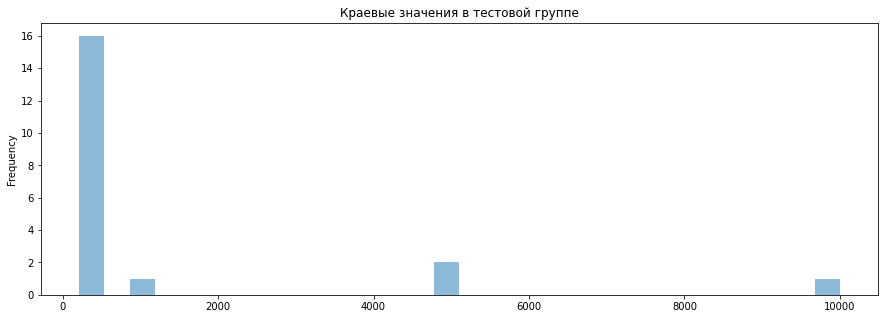

In [71]:
# Т.к. для тестовой группы стандартное отклонение разового пожертвования оказалось существенно больше,
# имеет смысл посмотреть на распределение краевых значений этой величины и сравнить их с контрольной группой

from matplotlib import pyplot as plt
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
ax.set_title('Краевые значения в тестовой группе')
print('Краевые значения в тестовой группе:')
client_result[(client_result.tag == 'test') & (client_result.AmountInUSD_one_time > 200)]['AmountInUSD_one_time'].plot.hist(bins=30, alpha=0.5, ax = ax)
client_result[(client_result.tag == 'test') & (client_result.AmountInUSD_one_time > 200)].dropna(subset=['AmountInUSD_one_time']).sort_values(by='AmountInUSD_one_time', ascending=False)['AmountInUSD_one_time'].head(10)

Краевые значения в контрольной группе:


40823    1000.0
26932    1000.0
13531     500.0
22817     500.0
15836     500.0
22862     500.0
2932      248.0
32802     237.0
19199     232.0
411       229.0
Name: AmountInUSD_one_time, dtype: float64

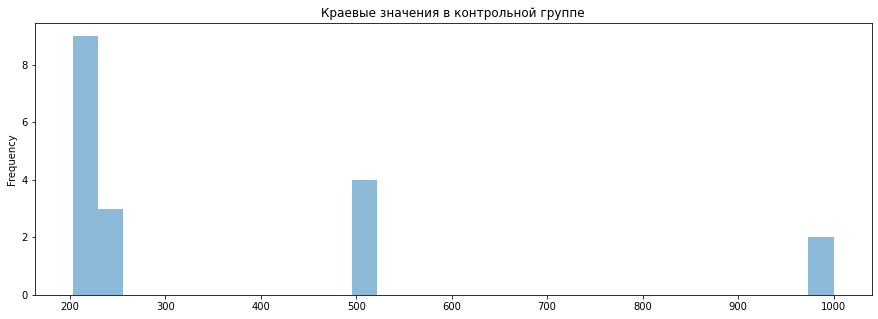

In [70]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
ax.set_title('Краевые значения в контрольной группе')
print('Краевые значения в контрольной группе:')
client_result[(client_result.tag == 'control') & (client_result.AmountInUSD_one_time > 200)]['AmountInUSD_one_time'].plot.hist(bins=30, alpha=0.5, ax = ax)
client_result[(client_result.tag == 'control') & (client_result.AmountInUSD_one_time > 200)].dropna(subset=['AmountInUSD_one_time']).sort_values(by='AmountInUSD_one_time', ascending=False)['AmountInUSD_one_time'].head(10)

In [246]:
fig0 = px.bar(client_result_agg, x='tag', y='AmountInUSD_one_time_sum', color='tag', title='Total one time donations, USD', width=500, height=400)
fig0.show()

fig1 = px.bar(client_result_agg, x='tag', y='AmountInUSD_recurring_sum', color='tag', title='Total recurring donations, USD', width=500, height=400)
fig1.show()

fig2 = px.bar(client_result_agg, x='tag', y='AmountInUSD_one_time_mean', color='tag', title='Mean one time donation, USD', width=500, height=400)
fig2.show()

fig3 = px.bar(client_result_agg, x='tag', y='AmountInUSD_recurring_mean', color='tag', title='Mean recurring donation, USD', width=500, height=400)
fig3.show()

fig4 = px.bar(client_result_agg, x='tag', y='Donated_share', color='tag', title='Share of clients who donated, %', width=500, height=400)
fig4.show()

fig5 = px.bar(client_result_agg, x='tag', y='AmountInUSD_one_time_median', color='tag', title='Median one time donation, USD', width=500, height=400)
fig5.show()

fig6 = px.bar(client_result_agg, x='tag', y='AmountInUSD_recurring_median', color='tag', title='Median recurring donation, USD', width=500, height=400)
fig6.show()

### Выводы

+ Из совокупности рассчитанных показателей видим, что общая сумма одиноразовых платежей в тестовой группе была значительно больше (разница чуть больше 7%)
+ Общая сумма регулярных платежей была незначительно больше в контрольной группе (разница меньше 1%)
+ Доля клиентов, сделавших пожертвование, также выше в тестовой группе почти на 1%
+ Также из изучения краевых значений суммы разового пожертвования видно, что на результаты значительно повлияли несколько значений 5000 и 10000 USD в тестовой группе

##### Из утверждений выше можно сделать вывод, что внесенное изменение в целом положительно повлияло на конвертацию и удержание пользователей, а также привлекло несколько пожертвований на суммы значительно крупнее средних

# Задание 2 
Компания получает в среднем 500 пожертвований в час с 10 до 12 часов дня. 
Найдите вероятность того, что за ближайшую минуту в сделают 
1) 10 пожертвований; 
2) От 5 до 7 пожертвований; 
При условии что сейчас 11-00 

Комментарий: задача должна быть решена без применения языков программирования, 
при необходимости можно использовать калькулятор. Помимо ответа в файле должен 
присутствовать ход решения задачи.  

Формат: решение нужно прислать в pdf, текстовом редакторе, фото или в любом другом 
доступном формате.

### Решение 

Т.к. пожертвования поступают независимо друг от друга с интенсивностью $\lambda$, случайная величина $X$, равная числу событий $k$, произошедших за фиксированное время, имеет распределение Пуассона. Для вычисления вероятности будем использовать формулу Пуассона: $$P_t(k)=\frac{(\lambda t)^k}{k!} e^{-\lambda t}$$

Здесь $\lambda=\frac{500}{60} \approx 8.3$. Получаем приблизительно 8.3 пожертвования в минуту

1) Вероятность получить 10 пожертвований:
$$P_1(10)=\frac{(8.3)^{10}}{10!} e^{-8.3} \approx 0.106$$

2) От 5 до 7 пожертвований - сложим вероятности получения 5, 6 и 7 пожертвований по использованной ранее формуле:
$$P_1(5 \leq k \leq 7)=P_1(5)+P_1(6)+P_1(7)=\frac{(8.3)^{5}}{5!} e^{-8.3} + \frac{(8.3)^{6}}{6!} e^{-8.3} + \frac{(8.3)^{7}}{7!} e^{-8.3} \approx 0.082 + 0.113 + 0.134 \approx 0.329$$

# Задание 3 
На шахматной доске размером 8x8 в левом верхнем углу стоит пешка. Она может ходить 
только вниз или право. Сколькими разными способами пешка может дойти до правого 
нижнего угла?  

Комментарий: задача должна быть решена без применения языков программирования, 
при необходимости можно использовать калькулятор. Помимо ответа в файле должен 
присутствовать ход решения задачи.  

Формат: решение нужно прислать в pdf, текстовом редакторе, фото или в любом другом 
доступном формате.

### Решение
Пешке нужно переместиться на 7 шагов вправо и на 7 шагов вниз. Т.к. количество таких путей равно количеству комбинаций 14 шагов, 7 из которых вниз, а остальные 7 - вправо, проблему сводится к тому, сколько есть таких последовательностей шагов.

Если мы точно знаем, на каких 7 из 14 шагов пешка пошла вниз, то мы знаем, что на остальных 7 шагах она пошла вправо. Таким образом, проблема эквивалентна поиску, сколькими способами мы можем выбрать 7 мест из упорядоченной последовательности из 14 мест (эти выбранные будут шагами «вниз»). Это число обозначается $\binom{14}{7}$, или в общем случае для n объектов, из которых выбрираются k объектов, количество таких выборов обозначается $\binom{n}{k}$.

Вычислим значение $\binom{14}{7}$. Есть 14 вариантов для первого выбора, 13 вариантов для второго и т.д., пока мы не выберем 7-й из оставшихся 8 вариантов. Таким образом, это равно 14⋅13⋅12⋅11⋅10⋅9⋅8, но тогда надо еще и делить на количество перестановок 7-х шагов, так как не важно, делает ли пешка, первый шаг на первом выборе, а второй на втором, или наоборот, так что у нас есть $\frac{14!}{7! 7!}$, или в общем случае $\frac{n!}{k!(n−k!)}$

Таким образом, количество способов равно: $$\frac{14!}{7! 7!}=3432$$


# Задание 4 
Клиентами являются компании из разных отраслей. Каждая из компаний может 
самостоятельно создавать различные кампании (виджеты) с разным описанием и разным 
набором настроек. Пользователи, совершающие пожертвования, всегда делают это в одну 
из таких кампаний, а не в компанию в целом. Таким образом, каждый донат “прикреплен” в 
какой-то определенной кампании (виджету), которая, в свою очередь, принадлежит какой-
то определенной компании. 

В БД есть 3 таблицы: 
1) Таблица charges, содержащая донаты пользователей:

Event_date ClientID AmountInUSD Campaign_key

2022-01-01 1234567 100.00 ABCDEF

2) Таблица widgets, содержащая информацию о кампаниях (виджетах):

Campaign_key Campaign_name Company_key Company_name

ABCDEF       My_campaign   GHIJKLM     My_company

3) Таблица websites_events, содержащая логи пользователей:

EventTime           EventType ClientID ...

2022-01-01 12:05:05 PageView  1234567 ...

Нужно написать SQL запрос, который для каждого campaign_name выводит Event_date и 
ClientID пользователя, совершившего максимальный донат (по полю AmountInUSD), и 
соответствует следующим критериям: 
- Не выводит виджеты, которые принадлежат компании ‘My_company’ 
- Не учитывает пользователей, которые в день совершения доната совершали событие c 
EventType = ‘elementView’

~~~sql
/* считаем, что требуется вывести один clientid и event_date с максимальной суммой доната по каждому campaign_name, 
   а не все clientid и event_date с максимальной суммой доната, если бы такие донаты с одинаковой максимальной суммой встречались несколько раз*/
   
with elementview as (
  select distinct 
         clientid
       , cast(eventtime as date) as event_date 
    from websites_events
   where eventtype = 'elementView')
   
select distinct
       w.campaign_name
     , first_value(c.event_date) over (partition by w.campaign_name order by c.amountinusd desc, c.clientid desc) as event_date
     , first_value(c.clientid) over (partition by w.campaign_name order by c.amountinusd desc, c.clientid desc) as clientid
  from widgets w
   left join charges c -- left join чтобы показать, что донатов не было
    on w.campaign_key = c.campaign_key
   left join elementview e -- считаем, что требуется исключить донат пользователя, совершенный в один день с событием elementView, а не исключить пользователя совсем
    on c.clientid = e.clientid
   and c.event_date = e.event_date
 where e.clientid is null
   and (w.company_name <> 'My_company' or w.company_name is null)
~~~